In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import wandb

In [2]:
ENTITY_NAME = "sketchy-opts"
PROJECT_NAME_BASE = "gp_inference_"
METRIC_NAME_BASE = "metrics.callback."

dataset = "malonaldehyde"
metric = "test_rmse"

In [3]:
api = wandb.Api()

In [4]:
runs = api.runs(f"{ENTITY_NAME}/{PROJECT_NAME_BASE}{dataset}")

In [5]:
print(runs)

<Runs sketchy-opts/gp_inference_malonaldehyde>


In [6]:
for run in runs:
    solver_name = run.config["solver_name"]
    if solver_name == "sap":
        if run.config["solver_config"].get("precond_config", None):
            print("sap nystrom")
        else:
            print("sap no precond")
    elif solver_name == "sdd":
        print(f"unscaled_step_size = {run.config['opt_step_size_unscaled']}")
    elif solver_name == "pcg":
        if run.config["solver_config"].get("precond_config", None):
            print("pcg nystrom")
    else:
        raise ValueError(f"Unknown solver name: {solver_name}")

sap nystrom
sap no precond
unscaled_step_size = 1
unscaled_step_size = 10
unscaled_step_size = 100
pcg nystrom
sap nystrom
sap no precond
unscaled_step_size = 1
unscaled_step_size = 10
unscaled_step_size = 100
pcg nystrom
sap nystrom
sap no precond
unscaled_step_size = 1
unscaled_step_size = 10
unscaled_step_size = 100
pcg nystrom
sap nystrom
sap no precond
unscaled_step_size = 1
unscaled_step_size = 10
unscaled_step_size = 100
pcg nystrom
sap nystrom
sap no precond
unscaled_step_size = 1
unscaled_step_size = 10
unscaled_step_size = 100
pcg nystrom


In [7]:
def render_in_latex():
    plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

In [ ]:
@dataclass(kw_only=True, frozen=True)
class MetricData:
    metric_data: np.ndarray
    steps: np.ndarray
    cum_times: np.ndarray
    finished: bool

    def get_final_time(self) -> float:
        """Return the last element in the cum_times array."""
        if len(self.cum_times) == 0:
            raise ValueError("cum_times array is empty.")
        return self.cum_times[-1]

class WandbRun:
    def __init__(self, run):
        self.run = run

    def _get_opt_name(self) -> str:
        if self.run.config["solver_name"] == "sap":
            if self.run.config["solver_config"].get("precond_config", None):
                return r"\texttt{ADASAP}"
            else:
                return r"\texttt{ADASAP-I}"
        elif self.run.config["solver_name"] == "sdd":
            return f"SDD-{self.run.config['opt_step_size_unscaled']}"
        elif self.run.config["solver_name"] == "pcg":
            if self.run.config["solver_config"].get("precond_config", None):
                return "PCG"
        else:
            raise ValueError(f"Unknown solver name: {self.run.config['solver_name']}")
    
    @property
    def opt_name(self) -> str:
        return self._get_opt_name()
        
    def get_metric_data(self, metric: str) -> MetricData:
        full_metric_name = f"{METRIC_NAME_BASE}{metric}"
        run_hist = self.run.scan_history(
            keys=[full_metric_name, "_step", "iter_time"])

        # Extract raw data
        metric_data = np.array([x[full_metric_name] for x in run_hist])
        steps = np.array([x["_step"] for x in run_hist])
        times = np.array([x["iter_time"] for x in run_hist])

        # Identify unique step indices -- this is needed to remove duplicates
        _, unique_indices = np.unique(steps, return_index=True)
        unique_indices = np.sort(unique_indices)  # Sort to maintain original order

        # Filter to keep only unique step entries
        metric_data = metric_data[unique_indices]
        times = times[unique_indices]
        steps = steps[unique_indices]

        # Calculate cumulative times
        cum_times = np.cumsum(times)

        return MetricData(
            metric_data=metric_data,
            steps=steps,
            cum_times=cum_times,
            finished=True if self.run.state == "finished" else False,
        )

In [9]:
metrics_dict = {}
for run in runs:
    run_obj = WandbRun(run)
    opt_name = run_obj.opt_name
    if opt_name not in metrics_dict:
        metrics_dict[opt_name] = []

    metric_data = run_obj.get_metric_data(metric)
    metrics_dict[opt_name].append(metric_data)


In [10]:
metrics_dict

{'\\texttt{ADASAP}': [MetricData(metric_data=array([1.00279844, 0.13014534, 0.09407645, 0.07707927, 0.06631751,
         0.05852862, 0.05264318, 0.04791429, 0.04420524, 0.041101  ,
         0.03853362, 0.03646176, 0.03467365, 0.03299841, 0.03165539,
         0.03037728, 0.02930062, 0.02831575, 0.02739506, 0.02655632,
         0.02573292, 0.02500633, 0.02434668, 0.02377535, 0.02315906,
         0.02263218, 0.02212876, 0.02162046, 0.02122124, 0.02079293,
         0.02036348, 0.01997628, 0.01965002, 0.01926422, 0.01893299,
         0.01860671, 0.0183216 , 0.01802148, 0.01774754, 0.01746635,
         0.01720187, 0.0169627 , 0.01675117, 0.01645644, 0.01625643,
         0.01605927, 0.0158181 , 0.01563946, 0.01545465, 0.01525041,
         0.01504653]), steps=array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
         1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
         2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
         3300, 

3553.46506690979
3489.2112040519714
2757.142966032028
1109.4582419395447


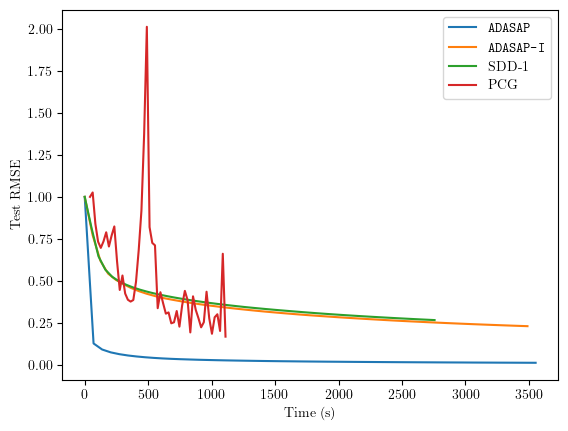

In [11]:
render_in_latex()

for opt_name, metric_data_list in metrics_dict.items():
    for opt_metric_data in metric_data_list[:1]:
        if opt_metric_data.finished:
            plt.plot(opt_metric_data.cum_times, opt_metric_data.metric_data, label=opt_name)
            print(opt_metric_data.get_final_time())
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Test RMSE")
plt.show()